In [1]:
import numpy as np
import pandas as pd
import s3fs
import fbprophet
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

In [2]:
data = pd.read_csv('s3://bsa-correlation-one/electronics_data.csv', dtype={'gtin':'str'})

In [5]:
data['delta_price'] = (data.olist_price.values/data.competition_price.values)-1

In [7]:
df = data[['date', 'product_group','product_type', 'olist_price','delta_price', 'orders']].copy()

In [8]:
df['olist_price'] = round(df.olist_price,2)

In [9]:
df['delta_price'] = round(df.delta_price,3)

### Create price categories

In [14]:
price_cat = {}
for prod_type in df.product_type.unique():
    temp = df[df.product_type == prod_type].copy()
    price_cat[prod_type] = np.quantile(temp.olist_price.values, np.arange(0.25,1,0.25))

In [15]:
def price_range(prod_category, price):
    prices = price_cat[prod_category]
    if price < prices[0]:
        return 'A'
    elif price < prices[1]:
        return 'B'
    elif price < prices[2]:
        return 'C'
    else:
        return 'D'

In [16]:
df['price_category'] = df.apply(lambda row: price_range(row['product_type'], row['olist_price']), axis=1)

In [19]:
df_gr = df.groupby(['date','product_group','product_type','price_category'])\
          .agg({'orders':'sum', 'delta_price': 'mean'}).reset_index()

In [20]:
df_gr.head()

,date,product_group,product_type,price_category,orders,delta_price
0,2017-06-30,electronics,Celular,A,0.0,NaN
1,2017-06-30,electronics,Celular,B,0.0,NaN
2,2017-06-30,electronics,Celular,C,0.0,NaN
3,2017-06-30,electronics,Controle remoto,D,0.0,NaN
4,2017-06-30,electronics,Microfone,A,0.0,NaN


In [23]:
df_gr['group_type_price'] = df_gr.product_group + '_' + df_gr.product_type + '_' +df_gr.price_category

In [25]:
df_final = df_gr[['date','group_type_price','delta_price', 'orders']].copy()

In [33]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [35]:
df_final.rename(columns={'date':'ds', 'orders':'y'}, inplace=True)

In [36]:
df_final.head()

,ds,group_type_price,delta_price,y
0,2017-06-30,electronics_Celular_A,NaN,0.0
1,2017-06-30,electronics_Celular_B,NaN,0.0
2,2017-06-30,electronics_Celular_C,NaN,0.0
3,2017-06-30,electronics_Controle remoto_D,NaN,0.0
4,2017-06-30,electronics_Microfone_A,NaN,0.0


### Holidays

In [29]:
def get_holidays():
    """
    Get Black Friday dates
    """
    black_friday = pd.DataFrame({
                  'holiday': 'black_friday',
                  'ds': pd.to_datetime(['2017-11-24', '2018-11-23', '2019-11-29',
                                        '2020-11-27', '2021-11-26', '2022-11-25',
                                        '2023-11-24', '2024-11-29', '2025-11-28']),
                  'lower_window': -1,
                  'upper_window': 3,
                })

    xmas = pd.DataFrame({
                  'holiday': 'christmas',
                  'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25',
                                        '2020-12-25', '2021-12-25', '2022-12-25',
                                        '2023-12-25', '2024-12-25', '2025-12-25']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    new_year = pd.DataFrame({
                  'holiday': 'new_year',
                  'ds': pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01',
                                        '2020-01-01', '2021-01-01', '2022-01-01',
                                        '2023-01-01', '2024-01-01', '2025-01-01']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    carnival = pd.DataFrame({
                  'holiday': 'carnival',
                  'ds': pd.to_datetime(['2017-02-28', '2018-02-13', '2019-03-05',
                                        '2020-02-25', '2021-02-16', '2022-03-01',
                                        '2023-02-21', '2024-02-13', '2025-03-04']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    good_friday = pd.DataFrame({
                  'holiday': 'good_friday',
                  'ds': pd.to_datetime(['2018-03-18','2019-04-19','2020-04-10',
                                        '2021-04-02','2022-04-15','2023-04-07',
                                        '2024-03-29']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # long holidays

    monday = pd.DataFrame({
                  'holiday': 'monday',
                  'ds': pd.to_datetime(['2020-09-07','2020-10-12','2020-11-02',
                                        '2021-11-15']),
                  'lower_window': -2,
                  'upper_window': 0,
                })

    friday = pd.DataFrame({
                  'holiday': 'friday',
                  'ds': pd.to_datetime(['2018-09-07','2018-10-12','2018-11-02',
                                        '2019-11-15','2020-05-01']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # Different cases
    # 2019-12-30 (christmas and New year's eve from tuesday to wednesday. Monday was also affected)
    others = pd.DataFrame({
                  'holiday': 'others',
                  'ds': pd.to_datetime(['2019-12-23','2019-12-30']),
                  'lower_window': 0,
                  'upper_window': 0,
                })

    holidays = pd.concat((black_friday, xmas, new_year, carnival,
                         monday, friday, others))

    return holidays

In [30]:
holidays = get_holidays()

### Bottom-up prophet

In [41]:
temp = df_final[df_final['group_type_price']=='electronics_Celular_A'].copy()
temp['delta_price'] = temp.delta_price.fillna(value=temp.delta_price.mean())

In [66]:
models = {}
deltas = {}

for each in ['electronics_Celular_A']:
    temp = df_final[df_final['group_type_price']==each].copy()
    # fillna values with mean?
    temp['delta_price'] = temp.delta_price.fillna(value=temp.delta_price.mean())
    deltas[each] = temp['delta_price'].tolist()
    
    model = Prophet(yearly_seasonality=True, holidays=holidays,
                    interval_width=0.95, seasonality_mode='multiplicative')
    model.add_regressor('delta_price')
    model.fit(temp)
    

    models[each] = model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
m = models['electronics_Celular_A']
d = deltas['electronics_Celular_A']

In [58]:
delta_prediction = [-0.20]*7
deltas = d + delta

In [59]:
future = m.make_future_dataframe(periods=7, freq='D', include_history=True)
future['delta_price'] = deltas

In [60]:
fcst = m.predict(future)

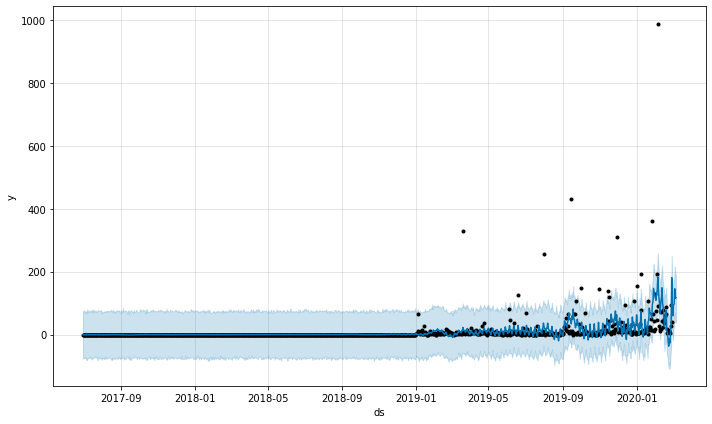

In [61]:
m.plot(fcst)
plt.show()

In [63]:
temp.tail(4)

,ds,group_type_price,delta_price,y
234443,2020-02-25,electronics_Celular_A,0.043231,5.0
234625,2020-02-26,electronics_Celular_A,0.050760,27.0
234802,2020-02-27,electronics_Celular_A,-0.086824,95.0
234929,2020-02-28,electronics_Celular_A,-0.400200,39.0


In [65]:
fcst.tail(7)[['ds','delta_price','yhat']]

,ds,delta_price,yhat
974,2020-02-29,2.95155,79.472476
975,2020-03-01,2.95155,59.727762
976,2020-03-02,2.95155,95.035437
977,2020-03-03,2.95155,97.146377
978,2020-03-04,2.95155,145.578132
979,2020-03-05,2.95155,115.505463
980,2020-03-06,2.95155,117.730910
